In [1]:
!pip install gdown

In [2]:
!gdown 1wL49U0RSJsgMfhQtyBjgbKkSo_bDjDlo

Downloading...
From: https://drive.google.com/uc?id=1wL49U0RSJsgMfhQtyBjgbKkSo_bDjDlo
To: /content/lending_sample.csv
100% 44.8M/44.8M [00:00<00:00, 57.3MB/s]


In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import pickle
from keras.callbacks import EarlyStopping
from keras.losses import BinaryCrossentropy
from keras.models import load_model
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold

# Classification

In [7]:
def preprocess_data(data):

  data.drop(data.columns[0], axis=1, inplace=True)

  missing_percentage = data.isnull().mean() * 100
  data = data[missing_percentage[missing_percentage <= 5].index]

  var_thr = VarianceThreshold(threshold = 0.25)
  var_thr.fit(data.drop(columns=['Month', 'class']))
  low_var = [column for column in data.drop(columns=['Month', 'class']).columns if column not in data.drop(columns=['Month', 'class']).columns[var_thr.get_support()]]
  data.drop(low_var,axis=1, inplace=True)

  columns = data.columns

  data['Month.Category'] = data['Month'].str[-2:].astype(int)
  data.drop('Month', axis=1, inplace=True)

  category_columns = [col for col in data.columns if 'Category' in col]

  for col in category_columns:
      if col != 'class':
        hasher = FeatureHasher(n_features=5, input_type='string')
        df_str = data[[col]].astype(str)
        dict_list = df_str.to_dict(orient='records')
        hashed_features = hasher.transform(dict_list)
        hashed_df = pd.DataFrame(hashed_features.toarray()).astype(int)
        hashed_col_names = [f'{col}_hash_{i}' for i in range(hashed_df.shape[1])]
        hashed_df.columns = hashed_col_names
        data.drop(columns=[col], inplace=True)

        data = pd.concat([data, hashed_df], axis=1)

  columns_with_nan = data.columns[data.isna().any()].tolist()

  for col in columns_with_nan:
      col_mean = data[col].mean()
      data[col].fillna(col_mean, inplace=True)

  return data, columns

def preprocess_input(data):

  data['Month.Category'] = data['Month'].str[-2:].astype(int)
  data.drop('Month', axis=1, inplace=True)

  category_columns = [col for col in data.columns if 'Category' in col]

  for col in category_columns:
    hasher = FeatureHasher(n_features=5, input_type='string')
    df_str = data[[col]].astype(str)
    dict_list = df_str.to_dict(orient='records')
    hashed_features = hasher.transform(dict_list)
    hashed_df = pd.DataFrame(hashed_features.toarray()).astype(int)
    hashed_col_names = [f'{col}_hash_{i}' for i in range(hashed_df.shape[1])]
    hashed_df.columns = hashed_col_names
    data.drop(columns=[col], inplace=True)
    data = pd.concat([data, hashed_df], axis=1)

  columns_with_nan = data.columns[data.isna().any()].tolist()

  for col in columns_with_nan:
      col_mean = data[col].mean()
      data[col].fillna(col_mean, inplace=True)

  return data

def build_model(input_dim):

  model = Sequential()
  model.add(Dense(25, activation="relu", input_dim=(input_dim)))
  model.add(Dense(20, activation="relu"))
  model.add(Dense(15, activation="relu"))
  model.add(Dense(10, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))

  return model

def train(model, data):
  x_train, x_val, y_train, y_val = train_test_split(data.drop(columns=['class']), data[['class']], test_size=0.2, random_state=1, shuffle=True)

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

  early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

  history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=150, validation_data=(x_val, y_val), callbacks=[early_stopping])

  return model, history

def display_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

<ipython-input-7-b402e4287e70>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(low_var,axis=1, inplace=True)
<ipython-input-7-b402e4287e70>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Month.Category'] = data['Month'].str[-2:].astype(int)
<ipython-input-7-b402e4287e70>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('Month', axis=1, inplace=True

Epoch 1/150
160/160 [==============================] - 2s 7ms/step - loss: 0.4560 - accuracy: 0.6523 - val_loss: 0.3424 - val_accuracy: 0.7363
Epoch 2/150
160/160 [==============================] - 1s 7ms/step - loss: 0.2252 - accuracy: 0.7675 - val_loss: 0.1611 - val_accuracy: 0.7905
Epoch 3/150
160/160 [==============================] - 1s 7ms/step - loss: 0.1555 - accuracy: 0.7901 - val_loss: 0.1452 - val_accuracy: 0.7952
Epoch 4/150
160/160 [==============================] - 1s 4ms/step - loss: 0.1419 - accuracy: 0.7962 - val_loss: 0.1326 - val_accuracy: 0.8007
Epoch 5/150
160/160 [==============================] - 1s 5ms/step - loss: 0.1299 - accuracy: 0.7988 - val_loss: 0.1296 - val_accuracy: 0.7997
Epoch 6/150
160/160 [==============================] - 1s 5ms/step - loss: 0.1271 - accuracy: 0.7987 - val_loss: 0.1268 - val_accuracy: 0.8005
Epoch 7/150
160/160 [==============================] - 1s 5ms/step - loss: 0.1249 - accuracy: 0.7993 - val_loss: 0.1587 - val_accuracy: 0.7995

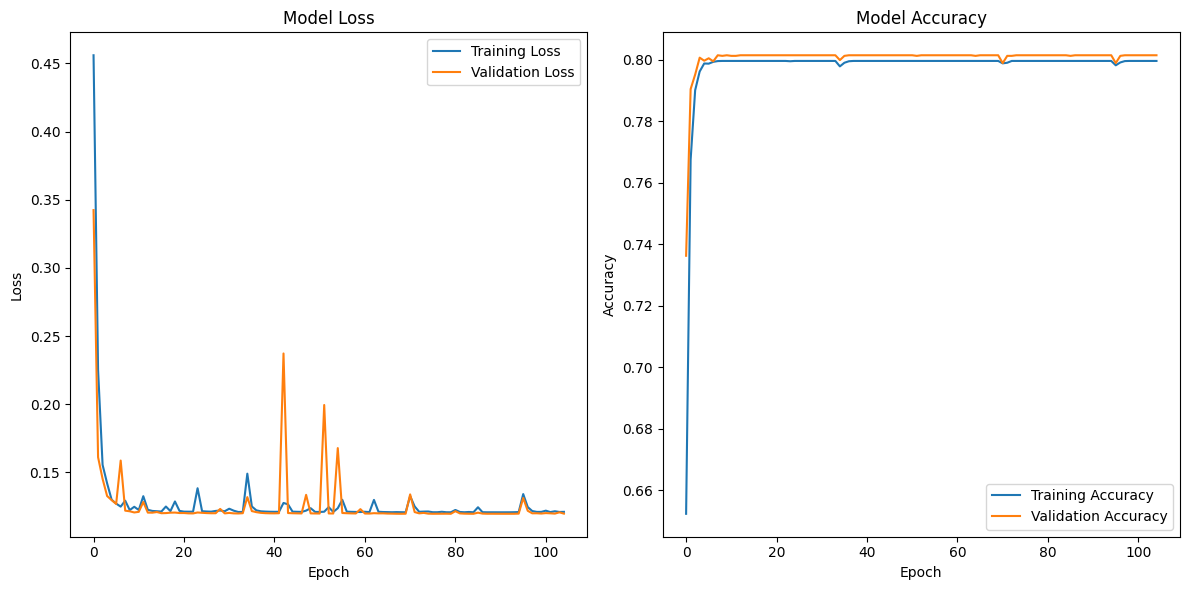


795/795 [==============================] - 1s 2ms/step
AUROC: 0.9996572995202193
Gini Score: 0.9993145990404386


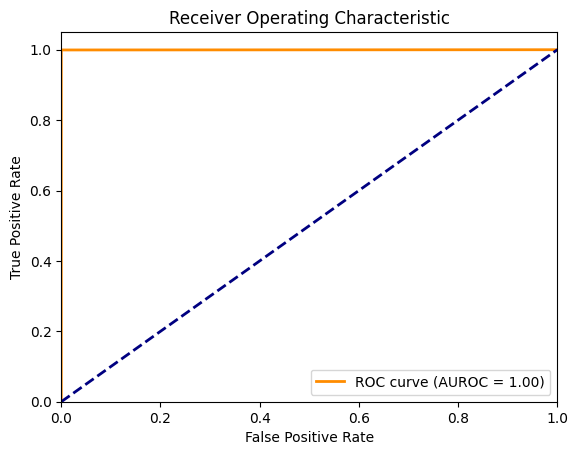

Classification Report:
              precision    recall  f1-score   support

           0   0.999958  1.000000  0.999979     23959
           1   1.000000  0.999315  0.999657      1459

    accuracy                       0.999961     25418
   macro avg   0.999979  0.999657  0.999818     25418
weighted avg   0.999961  0.999961  0.999961     25418



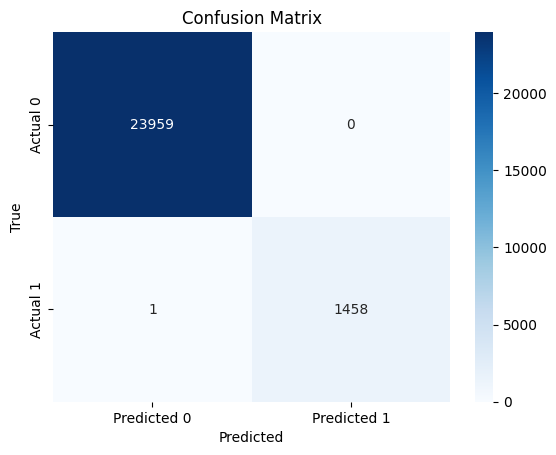

In [22]:
def run(csv):
  input_data = pd.read_csv(csv)
  train_data, test_data = train_test_split(input_data, test_size=0.2, random_state=1)

  train_data, columns = preprocess_data(train_data)

  test_data = preprocess_input(test_data[columns])

  input_dim = train_data.shape[1]-1
  model, history = train(build_model(input_dim), train_data)

  print('')
  print(history.history['val_loss'][-1])
  print(history.history['val_accuracy'][-1])
  display_history(history)
  print('')

  y_pred = model.predict(test_data.drop(columns='class'))
  y_true = test_data['class'].astype(int)
  y_pred_binary = (y_pred > 0.5).astype(int)

  fpr, tpr, _ = roc_curve(y_true, y_pred_binary)
  roc_auc = auc(fpr, tpr)

  auroc = roc_auc_score(y_true, y_pred_binary)

  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUROC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')

  gini_coefficient = 2 * auroc - 1
  print("AUROC:", auroc)
  print("Gini Score:", gini_coefficient)

  plt.show()

  cm = confusion_matrix(y_true, y_pred_binary)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

  print("Classification Report:")
  print(classification_report(y_true, y_pred_binary, digits=6))

  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  with open("model.pkl", "wb") as file:
      pickle.dump(model, file)

  with open("prediction.txt", "w") as file:
      file.write("Predicted labels (binary):\n")
      np.savetxt(file, y_pred_binary, fmt='%d')

if __name__ == "__main__":
  run('lending_sample.csv') #disesuaikan dengan nama/direktori file